## Term Project
### ID: eo9232
### Name: Md Reza
### CSC 5825 - Fall 2021

In [1]:
# Import requires packages and libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings
warnings.filterwarnings('ignore')
import math 
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from datetime import date, timedelta, datetime
from tabulate import tabulate

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import resample 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

## Load and Summarize the Data

In [2]:
def read_crData():
    df=pd.read_csv("/u/mreza6/5825/Data/creditcard.csv")
    return df

df=read_crData()

In [3]:
print(df["Class"].value_counts())

0    284315
1       492
Name: Class, dtype: int64


##### Distribution of Non-Fraudulent vs. Fraudulent Transactions

In [4]:
print('Non-Fraudulent Transactions:',round(df["Class"].value_counts()[0]/len(df)*100,2),'%')
print('Fraudulent Transactions    :',round(df["Class"].value_counts()[1]/len(df)*100,2),'%')

Non-Fraudulent Transactions: 99.83 %
Fraudulent Transactions    : 0.17 %


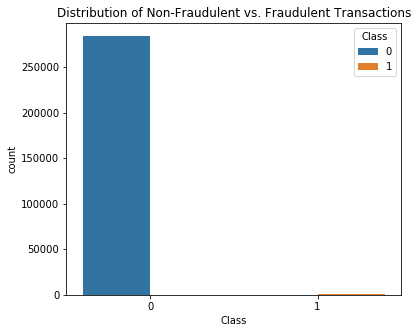

In [5]:
plt.figure(figsize=(6, 5))
var = sns.countplot(x=df.Class, hue=df.Class).set(title='Distribution of Non-Fraudulent vs. Fraudulent Transactions')

## Data Preprocessing and Visualization

##### PCA Transform the Time & Amount Features 

In [6]:
columns= df[['Time', 'Amount']]
pca = PCA()
pca.fit(columns)
X_PCA = pca.transform(columns)

df['PCA_Time']=X_PCA[:,0]
df['PCA_Amount']=X_PCA[:,1]

df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,PCA_Time,PCA_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,94813.862847,55.978567
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,94813.854647,-90.951433
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,94812.875630,285.018623
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,94812.861389,29.858623
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,94811.858403,-23.651321


##### Check for missing data

In [7]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,PCA_Amount,V15,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,V1
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Split the data for supervised learning

In [8]:
X_train, X_test= train_test_split(df, test_size=0.3, random_state=7)

In [9]:
print(X_train.shape)

(199364, 31)


##### Data prior to upsampling

In [10]:
print(X_test['Class'].value_counts())
X_test_t= X_test.drop(["Class"], axis=1)
Y_test= X_test["Class"]

0    85288
1      155
Name: Class, dtype: int64


##### Apply upsampling to the training data

In [11]:
non_fraud_class=X_train[X_train["Class"]==0]
fraud_class=X_train[X_train["Class"]==1]

resamp_fraudclass=resample(fraud_class,n_samples=199027,replace=True,random_state=42)
print(resamp_fraudclass.shape)

Xtrain_new= pd.concat([non_fraud_class,resamp_fraudclass])
Xtrain_new["Class"].value_counts()

(199027, 31)


1    199027
0    199027
Name: Class, dtype: int64

In [12]:
upsampling_X= Xtrain_new.drop(["Class"], axis=1)
upsampling_y= Xtrain_new["Class"]
print(upsampling_X.shape)

(398054, 30)


## Data Exploration

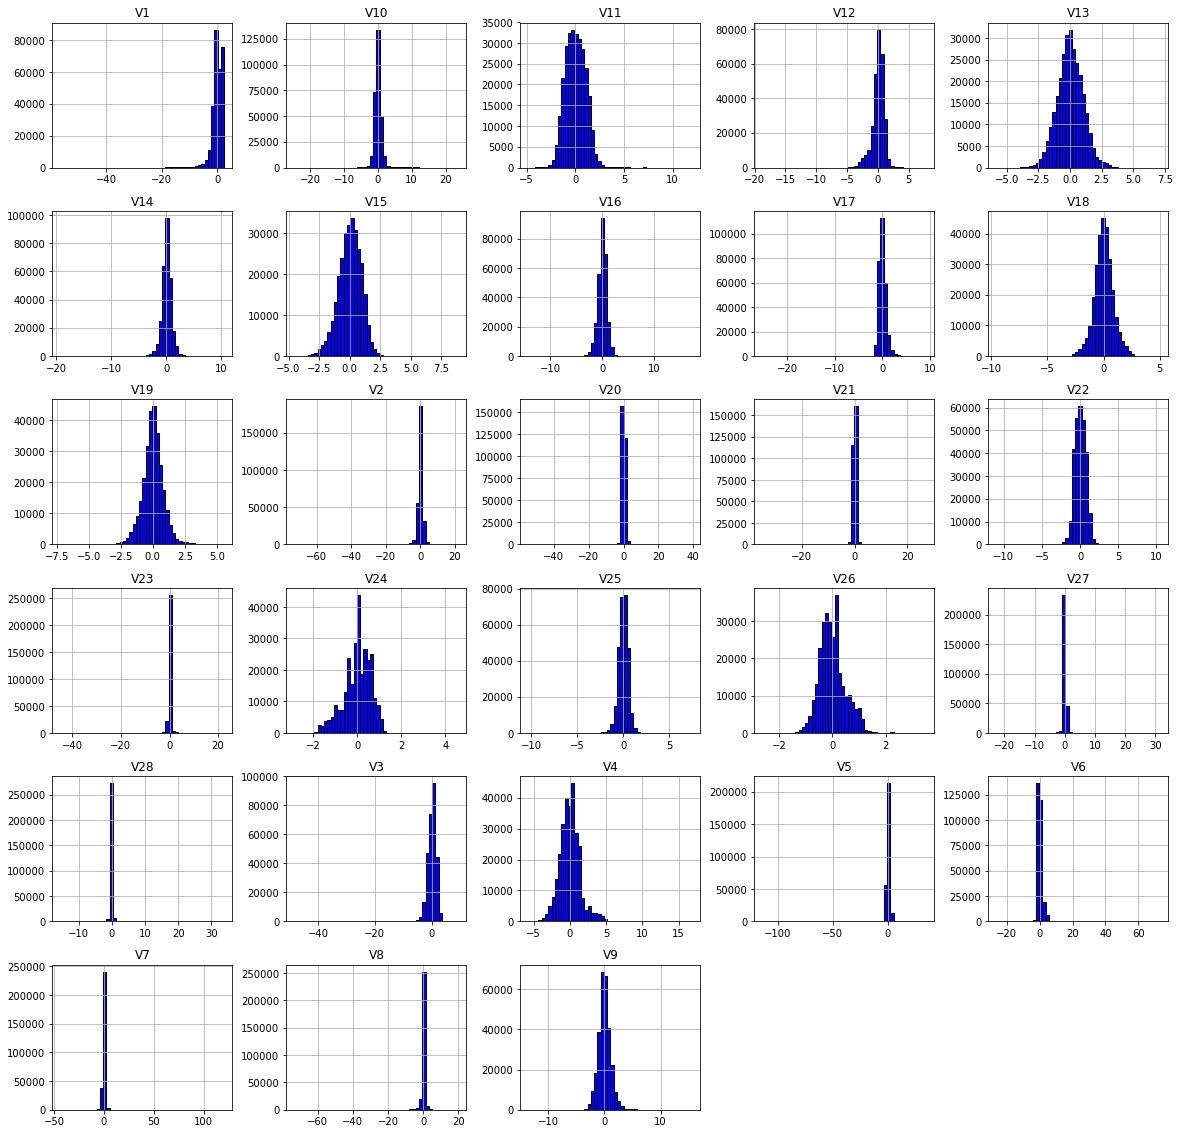

In [13]:
# create histograms on all features
df_hist = df.drop(['PCA_Time','PCA_Amount', 'Class'], 1)
df_hist.hist(figsize=(20,20), bins = 50, color = "b", edgecolor='black')
plt.show()

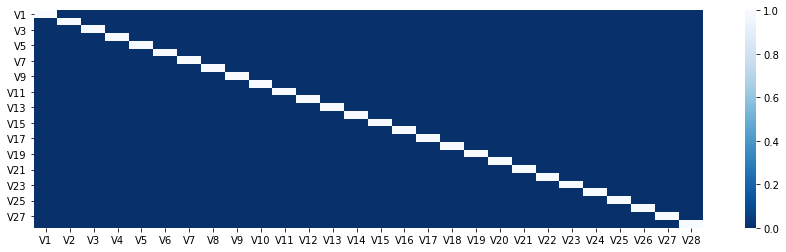

In [14]:
# feature correlation
plt.figure(figsize=(15,4))
f_cor = df_hist.corr()
ax=sns.heatmap(f_cor, cmap="Blues_r")

## Classification: Applying Supervised Machine Learning Algorithms

In [15]:
upsampling_pipe = []
upsampling_pipe.append(('Logistic Regression', Pipeline([('LR',LogisticRegression(max_iter=1000))])))
upsampling_pipe.append(('Decision Tree', Pipeline([('DT',DecisionTreeClassifier())])))
upsampling_pipe.append(('Naive Bayes', Pipeline([('NB',GaussianNB())])))

##### Post upsampling 10 fold cross validation 

In [16]:
upsamp_results = []
names = []
for name, model in upsampling_pipe:
    kfold = KFold(n_splits=10, random_state=None, shuffle=False)
    ups_cv_results = cross_val_score(model, upsampling_X, upsampling_y, cv=kfold)
    upsamp_results.append(ups_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, ups_cv_results.mean(), ups_cv_results.std())
    print(msg)

Logistic Regression: 0.935164 (0.035610)
Decision Tree: 0.999794 (0.000231)
Naive Bayes: 0.862879 (0.127681)


##### Logistic Regression with training & test data

In [17]:
LR=LogisticRegression(max_iter=1000)
                
kF= KFold(n_splits=10, random_state=None, shuffle=False)
LR.fit(upsampling_X, upsampling_y)
LR_predictions=LR.predict(X_test_t)

model_name = 'Logistic Regression'
print(f'{model_name} Model')

print("Accuracy Classification Score: ", accuracy_score(Y_test,LR_predictions),"\n")
print("Classification Report:\n" , classification_report(Y_test, LR_predictions))
lr_model_score = score(LR_predictions, Y_test,average='macro')
print(f'f1_score: {np.round(lr_model_score[2]*100, 2)}%')

cm_lr = metrics.confusion_matrix(Y_test, LR_predictions)
print("\nConfusion matrix")
print(pd.DataFrame(cm_lr))

performance_df = pd.DataFrame().append({'model_name':model_name, 
                                    'precision': lr_model_score[0], 
                                    'recall': lr_model_score[1], 
                                    'f1_score': lr_model_score[2]}, ignore_index=True)

Logistic Regression Model
Accuracy Classification Score:  0.9740411736479291 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85288
           1       0.06      0.92      0.11       155

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443

f1_score: 55.02%

Confusion matrix
       0     1
0  83083  2205
1     13   142


##### Decision Tree with training and test data

In [18]:
DT=DecisionTreeClassifier()
                
kF= KFold(n_splits=10, random_state=None, shuffle=False)
DT.fit(upsampling_X, upsampling_y)
DT_predictions=DT.predict(X_test_t)

model_name = 'Decision Tree'
print(f'{model_name} Model')

print("Accuracy Classification Score: ", accuracy_score(Y_test, DT_predictions),"\n")
print("Classification Report:\n" , classification_report(Y_test, DT_predictions))
dt_model_score = score(DT_predictions, Y_test,average='macro')
print(f'f1_score: {np.round(dt_model_score[2]*100, 2)}%')

cm_dt = metrics.confusion_matrix(Y_test, DT_predictions)
print("\nConfusion matrix")
print(pd.DataFrame(cm_dt))

performance_df = performance_df.append({'model_name':model_name, 
                                    'precision': dt_model_score[0], 
                                    'recall': dt_model_score[1], 
                                    'f1_score': dt_model_score[2]}, ignore_index=True)

Decision Tree Model
Accuracy Classification Score:  0.9991456292499094 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85288
           1       0.78      0.74      0.76       155

    accuracy                           1.00     85443
   macro avg       0.89      0.87      0.88     85443
weighted avg       1.00      1.00      1.00     85443

f1_score: 87.93%

Confusion matrix
       0    1
0  85255   33
1     40  115


##### Naive Bayes with training and test data

In [19]:
NB=GaussianNB() 
                
kF= KFold(n_splits=10, random_state=None, shuffle=False)
NB.fit(upsampling_X, upsampling_y)
NB_predictions=NB.predict(X_test_t)

model_name = 'Naive Bayes'
print(f'{model_name} Model')

print("Accuracy Classification Score: ", accuracy_score(Y_test, NB_predictions),"\n")
print("Classification Report:\n" ,classification_report(Y_test, NB_predictions))
nb_model_score = score(NB_predictions, Y_test,average='macro')
print(f'f1_score: {np.round(nb_model_score[2]*100, 2)}%')

cm_nb = metrics.confusion_matrix(Y_test, NB_predictions)
print("\nConfusion matrix")
print(pd.DataFrame(cm_nb))

performance_df = performance_df.append({'model_name':model_name, 
                                    'precision': nb_model_score[0], 
                                    'recall': nb_model_score[1], 
                                    'f1_score': nb_model_score[2]}, ignore_index=True)

Naive Bayes Model
Accuracy Classification Score:  0.9906838477113398 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     85288
           1       0.14      0.79      0.24       155

    accuracy                           0.99     85443
   macro avg       0.57      0.89      0.62     85443
weighted avg       1.00      0.99      0.99     85443

f1_score: 61.57%

Confusion matrix
       0    1
0  84524  764
1     32  123


## Classification: Applying Unsupervised Machine Learning Algorithms

In [20]:
# Feature Selection using Z-test
def ztest(feature):
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    return zScore

In [21]:
# Two tailed Z-test with the level of significance of 0.01 where corresponding critical value of 2.58 is used
columns= df.drop('Class', axis=1).columns
normal= df[df.Class==0]
fraud= df[df.Class==1]
sample_size=len(fraud)
significant_features=[]
cvalue=2.58 

for i in columns:    
    z_value=ztest(i)    
    if( abs(z_value) >= cvalue):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

V1  is statistically significant
V2  is statistically significant
V3  is statistically significant
V4  is statistically significant
V5  is statistically significant
V6  is statistically significant
V7  is statistically significant
V9  is statistically significant
V10  is statistically significant
V11  is statistically significant
V12  is statistically significant
V14  is statistically significant
V16  is statistically significant
V17  is statistically significant
V18  is statistically significant
V19  is statistically significant
V20  is statistically significant
V21  is statistically significant
V24  is statistically significant
V27  is statistically significant
V28  is statistically significant
PCA_Time  is statistically significant
PCA_Amount  is statistically significant


In [22]:
significant_features.append('Class')
data= df[significant_features]
print('Statistically significant Features: ',data.shape)

Statistically significant Features:  (284807, 24)


In [23]:
##Calculate the Outlier Fraction
df_base = df.copy()
print('0 = Valid, 1 = Fraud')
value_counts = df_base['Class'].value_counts()
print(value_counts)
contamination_rate = value_counts[1]/value_counts[0]
print('Outlier Fraction: ',contamination_rate)

0 = Valid, 1 = Fraud
0    284315
1       492
Name: Class, dtype: int64
Outlier Fraction:  0.0017304750013189597


In [24]:
# Separate the classes from the train set
df_base = df.copy()
df_classes = df_base['Class']
df_train = df_base.drop(['Class'], axis=1)

# split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(df_train, df_classes, test_size=0.30, random_state=42)

In [25]:
# Define function to measure model performance
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset
    df_pred_test = X_test.copy()
    df_pred_test['Pred'] = model.predict(X_test)
    if map_labels:
        df_pred_test['Pred'] = df_pred_test['Pred'].map({1: 0, -1: 1})
       
    x_pred = df_pred_test['Pred'] 
    labels = np.unique(y_true)
    
    print(classification_report(x_pred, y_true))
    
    model_score = score(x_pred, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    # Print the confusion matrix
    cm_isf = confusion_matrix(x_pred, y_true, labels=labels)
    cm = pd.DataFrame(cm_isf, index=labels, columns=labels)
    print("\nConfusion matrix")
    print(cm)
    
    return model_score

##### Isolation Forest

In [26]:
# Define the parameter 
n_estimators=[50, 100]
max_features=[1.0, 5, 10]
bootstrap=[True]
param_grid = dict(n_estimators=n_estimators, max_features=max_features, bootstrap=bootstrap)

# Build the gridsearch
model_isf = IsolationForest(n_estimators=n_estimators, 
                            max_features=max_features, 
                            contamination=contamination_rate, 
                            bootstrap=False, 
                            n_jobs=-1)

# Define the f1 Scorer
f1_sc = make_scorer(f1_score, average='macro')

grid = GridSearchCV(estimator=model_isf, param_grid=param_grid, cv = 3, scoring=f1_sc)
grid_results = grid.fit(X=X_train, y=y_train)

# Evaluate model performance
model_name = 'Isolation Forest'
print(f'{model_name} Model')

best_model = grid_results.best_estimator_
map_labels = True
model_score = measure_performance(best_model, X_test, y_test, map_labels)
performance_df = performance_df.append({'model_name':model_name, 
                                    'precision': model_score[0], 
                                    'recall': model_score[1], 
                                    'f1_score': model_score[2]}, ignore_index=True)

Isolation Forest Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.31      0.31      0.31       136

    accuracy                           1.00     85443
   macro avg       0.65      0.65      0.65     85443
weighted avg       1.00      1.00      1.00     85443

f1_score: 65.39%

Confusion matrix
       0   1
0  85213  94
1     94  42


## Results and Evaluation

+----+------------+---------------------+-------------+----------+
|    |   f1_score | model_name          |   precision |   recall |
|----+------------+---------------------+-------------+----------|
|  0 |   0.879324 | Decision Tree       |    0.870774 | 0.888279 |
|  1 |   0.653861 | Isolation Forest    |    0.653861 | 0.653861 |
|  2 |   0.615699 | Naive Bayes         |    0.892295 | 0.569146 |
|  3 |   0.550168 | Logistic Regression |    0.945138 | 0.530173 |
+----+------------+---------------------+-------------+----------+ 



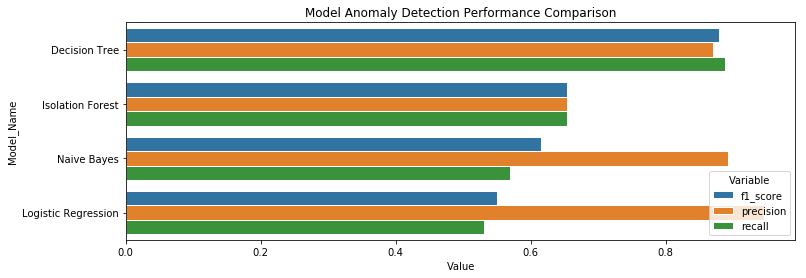

In [28]:
performance_df.reset_index(drop=True, inplace=True)
print(tabulate(performance_df, headers = 'keys', tablefmt = 'psql'),"\n")
performance_df = performance_df.sort_values('f1_score', ascending=False)

fig, ax = plt.subplots(figsize=(12, 4))
tbl = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tbl, ax=ax, palette='tab10', linewidth=1, edgecolor="w")
cmp=plt.title('Model Anomaly Detection Performance Comparison')

## Conclusion:

It turned out that F1-Score, Precision, & Recall play a key role in evaluating the performance of the models, and the goal was to capture possible fraudulent cases without raising false alarms too frequently. Key points to note:

1. The Decision Tree performs particularly well balanced.
2. The opposite is true for the Isolation Forest unsupervised model. Here, only a few fraud cases are detected, but the model is comparatively correct to identify fraud cases.
3. The Naive Bayes model has a slightly high F1-Score and detects many fraud cases. But it also raises false alarms very frequently.
4. The Logistic Regression model performs slightly worse than the other models.
